In [4]:
from gekko import GEKKO

In [5]:
m = GEKKO(remote=False)

In [10]:
N = m.SV(name='nutrient')

In [11]:
a.name

'a'

In [6]:
np.arange(0,365*5,10)

array([   0,   10,   20,   30,   40,   50,   60,   70,   80,   90,  100,
        110,  120,  130,  140,  150,  160,  170,  180,  190,  200,  210,
        220,  230,  240,  250,  260,  270,  280,  290,  300,  310,  320,
        330,  340,  350,  360,  370,  380,  390,  400,  410,  420,  430,
        440,  450,  460,  470,  480,  490,  500,  510,  520,  530,  540,
        550,  560,  570,  580,  590,  600,  610,  620,  630,  640,  650,
        660,  670,  680,  690,  700,  710,  720,  730,  740,  750,  760,
        770,  780,  790,  800,  810,  820,  830,  840,  850,  860,  870,
        880,  890,  900,  910,  920,  930,  940,  950,  960,  970,  980,
        990, 1000, 1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090,
       1100, 1110, 1120, 1130, 1140, 1150, 1160, 1170, 1180, 1190, 1200,
       1210, 1220, 1230, 1240, 1250, 1260, 1270, 1280, 1290, 1300, 1310,
       1320, 1330, 1340, 1350, 1360, 1370, 1380, 1390, 1400, 1410, 1420,
       1430, 1440, 1450, 1460, 1470, 1480, 1490, 15

In [29]:

# to measure process time
import time as tm

Model was solved in 0.86 seconds


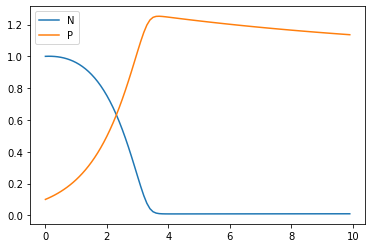

In [32]:
import numpy as np
from gekko import GEKKO
from scipy.integrate import odeint
import matplotlib.pyplot as plt

m = GEKKO(remote=False)    # create GEKKO model

halfsat_const = m.Param(0.1)
N0 = m.Param(1.)
inflow_rate = m.Param(0.1)
mortality_rate = m.Param(0.1)

N = m.SV(1, lb=0)
P = m.SV(0.1, lb=0, ub=2)

t = np.arange(0,10,.1)
m.time = t

# Growth under nutrient limitation is described via Monod / Michaelis-Menten kinetics
nutlim = m.Intermediate(N/(N+halfsat_const)*P)
N_influx = m.Intermediate(N0 * inflow_rate)
mortality = m.Intermediate(P * mortality_rate)

m.Equation(N.dt()==N_influx - nutlim)
m.Equation(P.dt()==nutlim - mortality)

m.options.NODES = 3
m.options.IMODE = 7


solve_start = tm.time()
m.solve(disp=False)
solve_end = tm.time()

m.cleanup()
print(f"Model was solved in {round(solve_end - solve_start, 2)} seconds")
    
plt.plot(m.time, N, label='N')
plt.plot(m.time, P, label='P')
plt.legend()

In [13]:
from gekko import GEKKO

class EQ(GEKKO.Equation):
    pass

TypeError: function() argument 'code' must be code, not str